# 2kr Analysis

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, chain, combinations
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def get_file_name(name):
    return name.replace(':', '-')

## Config

In [2]:
inputFile = 'data.csv'
repetitionsCount = -1 # -1 = auto-detect
factors = ['R', 'T', 'm', 'D']

tIntervalAlpha = 0.95

plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount', 'Floorplan.coveredUsers:sum', 'Floorplan.collisions:sum', 'Floorplan.msgsPerSlot:sum']
# Filter vectors
vectorsFilter = ['Floorplan.coveredUsers:vector']
# Percentiles
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

# Performance indexes
perfIndexes = [
    ('coveredUsersPercent', 'percentage of covered users'),
    ('Floorplan.collisions:sum', 'total number of collisions'),
    ('Floorplan.msgsPerSlot:sum', 'total number of messages sent'),
]

# Transformations
transformations = [
]

intPercentiles = [int(i*100) for i in percentiles]
vecPerfIndexes = []
for intPercentile in intPercentiles:
    vecPerfIndexes.append(('broadcastTime' + str(intPercentile), 'Broadcast time needed to reach the ' + str(intPercentile) + 'th percentile of the coverage'))
for v in vecPerfIndexes:
    perfIndexes.append(v)
    transformations.append((v[0], lambda x: math.log(x)))

## Load scalars

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

# Computed
factorsCount = len(factors)
configsCount = 2**factorsCount
totalSims = configsCount*repetitionsCount

combinedFactors = list(chain(*[list(map(''.join, combinations(''.join(factors), i))) for i in range(1, factorsCount+1)]))
freedomDegrees = configsCount*(repetitionsCount - 1)


display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', totalSims)
pd.set_option('display.max_columns', 2*configsCount*repetitionsCount+1)
if saveFigures:
    os.makedirs('figures', exist_ok=True)

Repetitions: 10


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
for index, row in scalars[scalars.type == 'itervar'].iterrows():
    val = scalars.loc[index, 'attrvalue']
    if isinstance(val, str)  and not all(c.isdigit() for c in val):
        scalars.loc[index, 'attrvalue'] = eval(val)
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values([*factors, 'repetition'], inplace=True)
count = 0
for index in scalars_wide.index:
    config = count // repetitionsCount
    scalars_wide.loc[index, 'config'] = config
    count += 1
scalars_wide = scalars_wide[['config', 'repetition', *factors, *scalarsFilter]]

# coverage
scalars_wide['coveredUsersPercent'] = scalars_wide['Floorplan.coveredUsers:sum'] / (scalars_wide['Floorplan.userCount'] - 1)

## Load vectors

In [6]:
vectors = df[df.type == 'vector']
vectors = vectors.assign(qname = vectors.module + '.' + vectors.name)
for index in scalars_wide.index:
    r = index
    cfg = scalars_wide.loc[index, 'config']
    rep = scalars_wide.loc[index, 'repetition']
    vectors.loc[vectors.run == r, 'config'] = cfg
    vectors.loc[vectors.run == r, 'repetition'] = rep
vectors = vectors[vectors.qname.isin(vectorsFilter)]
vectors.sort_values(['config', 'repetition', 'qname'], inplace=True)
vectors = vectors[['config', 'repetition', 'qname', 'vectime', 'vecvalue']]

## Compute scalars from vectors

In [7]:
def get_percentile(percentile, vectime, vecvalue, totalvalue):
    tofind = percentile * totalvalue
    idx = 0
    csum = vecvalue.cumsum()
    for value in csum:
        if value >= tofind:
            return vectime[idx]
        idx += 1
    return math.inf

for index, row in vectors.iterrows():
    for vecPerf, percentile in zip(vecPerfIndexes, percentiles):
        vecPerfIndex = vecPerf[0]
        cfg = row['config']
        rep = row['repetition']
        if vecPerfIndex.startswith('broadcastTime'):
            total = scalars_wide[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep)]['Floorplan.userCount'].values[0] - 1
        else:
            raise Exception('Need to specify total for ' + vecPerfIndex + '. (coding required)')
        value = get_percentile(percentile, row['vectime'], row['vecvalue'], total)
        scalars_wide.loc[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep), vecPerfIndex] = value

## Apply transformations

In [8]:
for col, transform in transformations:
    scalars_wide[col] = scalars_wide[col].map(transform, 'ignore')

## 2kr

In [9]:
cols = ['exp', 'I'] + combinedFactors
data = [[e, 1] + list(chain(*[list(map(np.prod, combinations(r, i))) for i in range(1, len(r)+1)])) for r,e in zip([list(x) for x in product([-1, 1], repeat=factorsCount)], range(0, configsCount))]
factorsMatrix = pd.DataFrame.from_records(data, columns=cols, index='exp')

computeMatrices = []
ciMatrices = []
errorVariances = []
skipped = []

for perfIndex, perfIndexDesc in perfIndexes:
    print("2^k*r analysis for the", perfIndexDesc)
    cols = ['exp'] + ['y' + str(i) for i in range(0, repetitionsCount)]
    data = [[i] + scalars_wide[scalars_wide.config == i][perfIndex].values.tolist() for i in range(0, configsCount)]
    ysMatrix = pd.DataFrame.from_records(data, columns=cols, index='exp')
    ysMatrix['mean'] = ysMatrix.mean(axis=1)
    next2kr = False
    for r in range(0, repetitionsCount):
        for c in range(0, configsCount):
            if math.isinf(ysMatrix['y' + str(r)].values[c]):
                print('!!! Observations contain infinite values. Skipping...')
                print()
                skipped.append(perfIndex)
                next2kr = True
                break
        if next2kr:
            break
        ysMatrix['e' + str(r)] = ysMatrix['y' + str(r)] - ysMatrix['mean']
    if next2kr:
        continue

    matrix = pd.concat([factorsMatrix, ysMatrix], axis=1)

    computeCols = ['idx', 'I'] + combinedFactors + ['e' + str(r) for r in range(0, repetitionsCount)]
    data = [['Sum'], ['Mean (Qi)'], ['SSQ']]
    SSE = 0
    for col in computeCols[1:]:
        sumvalue = np.sum(matrix[col].values * matrix['mean'].values)
        data[0].append(sumvalue)
        data[1].append(sumvalue / configsCount)
        if col in ['e' + str(r) for r in range(0, repetitionsCount)]:
            ssq = np.sum(matrix[col].values * matrix[col].values)
            data[2].append(ssq)
            SSE += ssq
        else:
            data[2].append('')
    computeMatrix = pd.DataFrame.from_records(data, columns=computeCols, index='idx')

    data = [['(2^k)*r*(qi)^2'], ['Variation'], ['Variation%']]
    SST = SSE
    for col in combinedFactors:
        qi = computeMatrix.loc['Mean (Qi)', col]
        r2kqi2 = configsCount*repetitionsCount*(qi**2)
        data[0].append(r2kqi2)
        SST += r2kqi2
    data[0].append(SSE)
    idx = 1
    for col in combinedFactors:
        r2kqi2 = data[0][idx]
        var = r2kqi2 / SST
        data[1].append(var)
        data[2].append('{:.2%}'.format(var))
        idx += 1
    data[1].append(SST)
    data[2].append('{:.2%}'.format(SSE/SST))
    resultMatrix = pd.DataFrame.from_records(data, columns=['idx'] + combinedFactors + ['SSE/SST'], index='idx')

    errorVariance = SSE / freedomDegrees
    negativeInterval, positiveInterval = tuple(v*math.sqrt(errorVariance/(configsCount*repetitionsCount)) for v in stats.t.interval(tIntervalAlpha, freedomDegrees))
    data = [['CI+ Qi ({:.2%})'.format(tIntervalAlpha)], ['CI- Qi ({:.2%})'.format(tIntervalAlpha)], ['Distance (Qi)'], ['Zero Included'], ['CI+ Variation'], ['CI- Variation'], ['CI Distance (Variation)']]
    for col in combinedFactors:
        qi = computeMatrix.loc['Mean (Qi)', col]
        upper = qi + positiveInterval
        lower = qi + negativeInterval
        data[0].append(upper)
        data[1].append(lower)
        data[2].append(abs(upper - lower))
        data[3].append(upper >= 0 and lower <= 0)
        upper = (configsCount*repetitionsCount*(upper**2))/SST
        lower = (configsCount*repetitionsCount*(lower**2))/SST
        data[4].append(upper)
        data[5].append(lower)
        data[6].append(abs(upper - lower))
    ciMatrix = pd.DataFrame.from_records(data, columns=['idx'] + combinedFactors, index='idx')

    computeMatrices.append(computeMatrix)
    ciMatrices.append(ciMatrix)
    errorVariances.append(errorVariance)

    display(matrix)
    display(computeMatrix)
    display(resultMatrix)
    display(ciMatrix)

    print('SSE =', SSE)
    print('SST =', SST)
    print('Error variance =', errorVariance)
    print('Unexplained Variation =', '{:.2%}'.format(SSE/SST))
    print()
    print('####################################')
    print()

2^k*r analysis for the percentage of covered users


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,0.998666,0.999333,0.995997,0.998666,0.998666,1.000000,1.000000,1.000000,0.999333,0.999333,0.998999,-0.000334,0.000334,-0.003002,-0.000334,-0.000334,0.001001,0.001001,0.001001,0.000334,0.000334
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,1.000000,1.000000,1.000000,0.999333,1.000000,1.000000,1.000000,1.000000,0.999333,1.000000,0.999867,0.000133,0.000133,0.000133,-0.000534,0.000133,0.000133,0.000133,0.000133,-0.000534,0.000133
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999333,1.000000,1.000000,0.999933,0.000067,0.000067,0.000067,0.000067,0.000067,0.000067,0.000067,-0.000600,0.000067,0.000067
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,1.000000,1.000000,1.000000,1.000000,0.999333,1.000000,1.000000,1.000000,1.000000,1.000000,0.999933,0.000067,0.000067,0.000067,0.000067,-0.000600,0.000067,0.000067,0.000067,0.000067,0.000067
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,0.999333,1.000000,0.999333,1.000000,0.997332,1.000000,1.000000,1.000000,0.995330,0.999333,0.999066,0.000267,0.000934,0.000267,0.000934,-0.001734,0.000934,0.000934,0.000934,-0.003736,0.000267
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,1.000000,0.999333,1.000000,0.999333,0.999333,1.000000,0.999333,1.000000,1.000000,1.000000,0.999733,0.000267,-0.000400,0.000267,-0.000400,-0.000400,0.000267,-0.000400,0.000267,0.000267,0.000267
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999333,0.999933,0.000067,0.000067,0.000067,0.000067,0.000067,0.000067,0.000067,0.000067,0.000067,-0.000600
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,1.000000,1.000000,0.999333,1.000000,0.997999,0.999333,1.000000,1.000000,1.000000,1.000000,0.999666,0.000334,0.000334,-0.000334,0.000334,-0.001668,-0.000334,0.000334,0.000334,0.000334,0.000334


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,15.996197,0.001268,0.001001,0.001134,0.000867,0.001268,-0.002335,0.0006,0.000067,-0.002068,0.0002,0.000867,0.000867,-0.000067,0.002068,-0.001935,-0.000200,0.001800,-0.003532,-0.000867,-0.004200,0.003133,0.003133,0.002466,-0.002199,4.663683e-04
Mean (Qi),0.999762,0.000079,0.000063,0.000071,0.000054,0.000079,-0.000146,0.000038,0.000004,-0.000129,0.000013,0.000054,0.000054,-0.000004,0.000129,-0.000121,-0.000012,0.000112,-0.000221,-0.000054,-0.000263,0.000196,0.000196,0.000154,-0.000137,2.914802e-05
SSQ,,,,,,,,,,,,,,,,,0.000001,0.000002,0.000010,0.000003,0.000007,0.000003,0.000003,0.000003,0.000015,9.212279e-07


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,0.000001,0.000001,0.000001,0.0,0.000001,0.000003,0.0,0.0,0.000003,0.0,0.0,0.0,0.0,0.000003,0.000002,0.000046
Variation,0.016268,0.010139,0.013023,0.007616,0.016268,0.055203,0.00365,0.000045,0.043306,0.000406,0.007616,0.007616,0.000045,0.043306,0.037898,0.000062
Variation%,1.63%,1.01%,1.30%,0.76%,1.63%,5.52%,0.37%,0.00%,4.33%,0.04%,0.76%,0.76%,0.00%,4.33%,3.79%,73.76%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),0.000167,0.00015,0.000159,0.000142,0.000167,-0.000058,0.000125,0.000092,-0.000041,0.0001,0.000142,0.000142,0.000084,0.000217,-0.000033
CI- Qi (95.00%),-0.000009,-0.000025,-0.000017,-0.000034,-0.000009,-0.000234,-0.00005,-0.000084,-0.000217,-0.000075,-0.000034,-0.000034,-0.000092,0.000041,-0.000209
Distance (Qi),0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176,0.000176
Zero Included,True,True,True,True,True,False,True,True,False,True,True,True,True,False,False
CI+ Variation,0.072365,0.05864,0.065322,0.052318,0.072365,0.00874,0.040755,0.021956,0.004441,0.026115,0.052318,0.052318,0.018157,0.122194,0.002832
CI- Variation,0.000194,0.001662,0.000748,0.002937,0.000194,0.141688,0.006568,0.018157,0.122194,0.014719,0.002937,0.002937,0.021956,0.004441,0.112988
CI Distance (Variation),0.072172,0.056978,0.064575,0.049381,0.072172,0.132948,0.034187,0.003799,0.117754,0.011396,0.049381,0.049381,0.003799,0.117754,0.110157


SSE = 4.552734956504284e-05
SST = 6.172393781756347e-05
Error variance = 3.1616214975724196e-07
Unexplained Variation = 73.76%

####################################

2^k*r analysis for the total number of collisions


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,1245.0,1248.0,1148.0,1128.0,1136.0,1169.0,1184.0,978.0,1100.0,1031.0,1136.7,108.3,111.3,11.3,-8.7,-0.7,32.3,47.3,-158.7,-36.7,-105.7
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,659.0,748.0,635.0,669.0,650.0,612.0,685.0,636.0,676.0,801.0,677.1,-18.1,70.9,-42.1,-8.1,-27.1,-65.1,7.9,-41.1,-1.1,123.9
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,1318.0,1347.0,1369.0,1217.0,1383.0,1376.0,1353.0,1422.0,1355.0,1369.0,1350.9,-32.9,-3.9,18.1,-133.9,32.1,25.1,2.1,71.1,4.1,18.1
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,754.0,841.0,776.0,839.0,771.0,802.0,839.0,798.0,807.0,729.0,795.6,-41.6,45.4,-19.6,43.4,-24.6,6.4,43.4,2.4,11.4,-66.6
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,1087.0,970.0,984.0,926.0,985.0,876.0,1022.0,937.0,993.0,864.0,964.4,122.6,5.6,19.6,-38.4,20.6,-88.4,57.6,-27.4,28.6,-100.4
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,644.0,701.0,621.0,605.0,678.0,605.0,716.0,551.0,524.0,681.0,632.6,11.4,68.4,-11.6,-27.6,45.4,-27.6,83.4,-81.6,-108.6,48.4
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,1221.0,1350.0,1398.0,1336.0,1272.0,1211.0,1296.0,1332.0,1316.0,1304.0,1303.6,-82.6,46.4,94.4,32.4,-31.6,-92.6,-7.6,28.4,12.4,0.4
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,836.0,874.0,898.0,848.0,918.0,910.0,980.0,891.0,929.0,888.0,897.2,-61.2,-23.2,0.8,-49.2,20.8,12.8,82.8,-6.2,31.8,-9.2
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,5799.0,6278.0,5902.0,6006.0,5725.0,5788.0,6430.0,6145.0,6082.0,5887.0,6004.2,-205.2,273.8,-102.2,1.8,-279.2,-216.2,425.8,140.8,77.8,-117.2


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,48407.1,32890.9,-566.7,8746.1,-9132.3,-241.7,6873.1,-5626.1,5646.7,1882.7,-25.7,5104.5,1329.3,314.9,-263.5,-305.7,3.056262e+06,-1.174663e+06,4.167753e+06,374685.370000,-7.928940e+06,-2.254291e+06,150506.970000,1.062590e+06,2.496186e+06,49908.870000
Mean (Qi),3025.44375,2055.68125,-35.41875,546.63125,-570.76875,-15.10625,429.56875,-351.63125,352.91875,117.66875,-1.60625,319.03125,83.08125,19.68125,-16.46875,-19.10625,1.910164e+05,-7.341641e+04,2.604846e+05,23417.835625,-4.955587e+05,-1.408932e+05,9406.685625,6.641189e+04,1.560116e+05,3119.304375
SSQ,,,,,,,,,,,,,,,,,3.737779e+05,2.419805e+05,7.130357e+05,116409.730000,6.709195e+05,3.038497e+05,538966.530000,8.496329e+05,1.760543e+05,591008.730000


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,676132064.25625,200718.05625,47808915.75625,52124314.55625,36511.80625,29524689.75625,19783125.75625,19928263.05625,2215349.55625,412.80625,16284950.15625,1104399.05625,61976.25625,43395.15625,58407.80625,4575635.7
Variation,0.777268,0.000231,0.05496,0.059921,0.000042,0.033941,0.022742,0.022909,0.002547,0.0,0.018721,0.00127,0.000071,0.00005,0.000067,869883129.49375
Variation%,77.73%,0.02%,5.50%,5.99%,0.00%,3.39%,2.27%,2.29%,0.25%,0.00%,1.87%,0.13%,0.01%,0.00%,0.01%,0.53%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),2083.535906,-7.564094,574.485906,-542.914094,12.748406,457.423406,-323.776594,380.773406,145.523406,26.248406,346.885906,110.935906,47.535906,11.385906,8.748406
CI- Qi (95.00%),2027.826594,-63.273406,518.776594,-598.623406,-42.960906,401.714094,-379.485906,325.064094,89.814094,-29.460906,291.176594,55.226594,-8.173406,-44.323406,-46.960906
Distance (Qi),55.709311,55.709311,55.709311,55.709311,55.709311,55.709311,55.709311,55.709311,55.709311,55.709311,55.709311,55.709311,55.709311,55.709311,55.709311
Zero Included,False,False,False,False,True,False,False,False,False,True,False,False,True,True,True
CI+ Variation,0.798475,0.000011,0.060704,0.054215,0.00003,0.038485,0.019282,0.026668,0.003895,0.000127,0.022133,0.002264,0.000416,0.000024,0.000014
CI- Variation,0.756346,0.000736,0.049502,0.065912,0.000339,0.029682,0.026488,0.019436,0.001484,0.00016,0.015595,0.000561,0.000012,0.000361,0.000406
CI Distance (Variation),0.042128,0.000726,0.011202,0.011697,0.00031,0.008803,0.007206,0.007233,0.002411,0.000033,0.006538,0.001703,0.000403,0.000338,0.000392


SSE = 4575635.7
SST = 869883129.4937501
Error variance = 31775.247916666667
Unexplained Variation = 0.53%

####################################

2^k*r analysis for the total number of messages sent


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,1321.0,1321.0,1302.0,1284.0,1312.0,1320.0,1324.0,1297.0,1308.0,1252.0,1304.1,16.9,16.9,-2.1,-20.1,7.9,15.9,19.9,-7.1,3.9,-52.1
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,1356.0,1334.0,1342.0,1341.0,1344.0,1331.0,1343.0,1348.0,1335.0,1380.0,1345.4,10.6,-11.4,-3.4,-4.4,-1.4,-14.4,-2.4,2.6,-10.4,34.6
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1499.0,1500.0,1500.0,1499.9,0.1,0.1,0.1,0.1,0.1,0.1,0.1,-0.9,0.1,0.1
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,1212.0,1204.0,1188.0,1158.0,1196.0,1162.0,1169.0,1175.0,1203.0,1151.0,1181.8,30.2,22.2,6.2,-23.8,14.2,-19.8,-12.8,-6.8,21.2,-30.8
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,1132.0,1138.0,1112.0,1128.0,1146.0,1138.0,1165.0,1116.0,1088.0,1139.0,1130.2,1.8,7.8,-18.2,-2.2,15.8,7.8,34.8,-14.2,-42.2,8.8
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,1495.0,1496.0,1498.0,1496.0,1494.0,1498.0,1499.0,1497.0,1500.0,1500.0,1497.3,-2.3,-1.3,0.7,-1.3,-3.3,0.7,1.7,-0.3,2.7,2.7
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,1497.0,1495.0,1494.0,1493.0,1497.0,1489.0,1499.0,1497.0,1498.0,1497.0,1495.6,1.4,-0.6,-1.6,-2.6,1.4,-6.6,3.4,1.4,2.4,1.4
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,1316.0,1346.0,1333.0,1354.0,1344.0,1335.0,1357.0,1345.0,1322.0,1343.0,1339.5,-23.5,6.5,-6.5,14.5,4.5,-4.5,17.5,5.5,-17.5,3.5


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,21041.2,-867.4,-1430.8,2865.8,-277.6,-741.8,803.2,-253.4,1343.4,-178.8,247.0,682.4,10.2,230.0,146.6,-36.0,90049.5600,15235.9600,76661.360,12044.66000,-32999.54000,-56689.6400,-101081.44,-40688.54000,-24563.34000,62030.960
Mean (Qi),1315.075,-54.2125,-89.425,179.1125,-17.35,-46.3625,50.2,-15.8375,83.9625,-11.175,15.4375,42.65,0.6375,14.375,9.1625,-2.25,5628.0975,952.2475,4791.335,752.79125,-2062.47125,-3543.1025,-6317.59,-2543.03375,-1535.20875,3876.935
SSQ,,,,,,,,,,,,,,,,,5544.3400,1730.5400,10043.740,2263.14000,7890.54000,3532.7400,14584.34,9372.54000,7610.14000,15128.540


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,470239.225,1279492.9,5133006.025,48163.6,343917.025,403206.4,40132.225,1127952.225,19980.9,38130.625,291043.6,65.025,33062.5,13432.225,810.0,77700.6
Variation,0.050453,0.13728,0.550732,0.005168,0.0369,0.043261,0.004306,0.121021,0.002144,0.004091,0.031227,0.000007,0.003547,0.001441,0.000087,9320335.1
Variation%,5.05%,13.73%,55.07%,0.52%,3.69%,4.33%,0.43%,12.10%,0.21%,0.41%,3.12%,0.00%,0.35%,0.14%,0.01%,0.83%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-50.582687,-85.795187,182.742313,-13.720187,-42.732687,53.829813,-12.207687,87.592313,-7.545187,19.067313,46.279813,4.267313,18.004813,12.792313,1.379813
CI- Qi (95.00%),-57.842313,-93.054813,175.482687,-20.979813,-49.992313,46.570187,-19.467313,80.332687,-14.804813,11.807687,39.020187,-2.992313,10.745187,5.532687,-5.879813
Distance (Qi),7.259626,7.259626,7.259626,7.259626,7.259626,7.259626,7.259626,7.259626,7.259626,7.259626,7.259626,7.259626,7.259626,7.259626,7.259626
Zero Included,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
CI+ Variation,0.043923,0.126361,0.57328,0.003232,0.031348,0.049743,0.002558,0.131711,0.000977,0.006241,0.036768,0.000313,0.005565,0.002809,0.000033
CI- Variation,0.057435,0.14865,0.528636,0.007556,0.042904,0.037231,0.006506,0.110783,0.003763,0.002393,0.026138,0.000154,0.001982,0.000525,0.000593
CI Distance (Variation),0.013512,0.022289,0.044644,0.004324,0.011556,0.012512,0.003947,0.020928,0.002785,0.003848,0.01063,0.000159,0.003583,0.002284,0.000561


SSE = 77700.59999999999
SST = 9320335.099999994
Error variance = 539.5875
Unexplained Variation = 0.83%

####################################

2^k*r analysis for the Broadcast time needed to reach the 25th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,3.850148,3.931826,4.127134,4.110874,4.174387,3.912023,4.143135,3.784190,3.761200,4.110874,3.990579,-0.140431,-0.058753,0.136555,0.120295,0.183808,-0.078556,0.152556,-0.206389,-0.229379,0.120295
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,4.418841,4.204693,4.043051,4.158883,4.043051,4.007333,4.094345,4.330733,4.110874,4.110874,4.152268,0.266573,0.052425,-0.109216,0.006615,-0.109216,-0.144935,-0.057923,0.178466,-0.041394,-0.041394
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,3.784190,3.912023,3.970292,3.761200,4.262680,4.189655,4.007333,3.713572,3.806662,4.290459,3.969807,-0.185617,-0.057784,0.000485,-0.208607,0.292873,0.219848,0.037527,-0.256235,-0.163144,0.320653
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,4.127134,4.595120,4.060443,3.970292,4.158883,4.094345,4.043051,3.891820,3.912023,3.970292,4.082340,0.044794,0.512780,-0.021897,-0.112048,0.076543,0.012004,-0.039289,-0.190520,-0.170317,-0.112048
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,4.488636,4.488636,4.465908,4.204693,4.304065,4.394449,4.248495,4.330733,4.499810,4.382027,4.380745,0.107891,0.107891,0.085163,-0.176053,-0.076680,0.013704,-0.132250,-0.050012,0.119064,0.001281
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,4.521789,4.787492,4.634729,4.584967,5.087596,4.962845,4.736198,4.691348,4.727388,4.317488,4.705184,-0.183395,0.082308,-0.070455,-0.120217,0.382412,0.257661,0.031014,-0.013836,0.022204,-0.387696
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,4.382027,4.276666,4.543295,4.418841,4.644391,4.465908,4.330733,4.653960,4.700480,4.521789,4.493809,-0.111782,-0.217143,0.049486,-0.074968,0.150582,-0.027901,-0.163076,0.160151,0.206671,0.027980
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,4.418841,4.682131,4.564348,4.595120,4.615121,4.709530,4.488636,4.488636,4.762174,4.553877,4.587841,-0.169001,0.094290,-0.023493,0.007278,0.027279,0.121689,-0.099205,-0.099205,0.174333,-0.033965
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,3.044522,2.833213,3.091042,2.890372,2.833213,2.708050,2.944439,3.044522,3.178054,2.890372,2.945780,0.098742,-0.112567,0.145262,-0.055408,-0.112567,-0.237730,-0.001341,0.098742,0.232274,-0.055408


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,60.587413,-8.137734,4.093077,-0.147391,1.152941,0.147905,0.042566,-0.232446,-0.126417,0.175152,-0.427003,-0.299259,-0.113345,0.13212,-0.380354,-0.017852,-0.227871,2.218570,-1.131921,-6.446343,2.563052,3.367580,0.495959,-0.533867,-0.403785,0.098628
Mean (Qi),3.786713,-0.508608,0.255817,-0.009212,0.072059,0.009244,0.00266,-0.014528,-0.007901,0.010947,-0.026688,-0.018704,-0.007084,0.008258,-0.023772,-0.001116,-0.014242,0.138661,-0.070745,-0.402896,0.160191,0.210474,0.030997,-0.033367,-0.025237,0.006164
SSQ,,,,,,,,,,,,,,,,,0.367712,0.541325,0.364322,0.372270,0.645423,0.891494,0.646860,0.543158,0.385566,0.477174


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,41.389198,10.470799,0.013578,0.830796,0.013672,0.001132,0.03377,0.009988,0.019174,0.113957,0.055972,0.008029,0.01091,0.090418,0.000199,5.235304
Variation,0.709973,0.179612,0.000233,0.014251,0.000235,0.000019,0.000579,0.000171,0.000329,0.001955,0.00096,0.000138,0.000187,0.001551,0.000003,58.296897
Variation%,71.00%,17.96%,0.02%,1.43%,0.02%,0.00%,0.06%,0.02%,0.03%,0.20%,0.10%,0.01%,0.02%,0.16%,0.00%,8.98%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.478813,0.285612,0.020583,0.101854,0.039039,0.032455,0.015267,0.021894,0.040742,0.003107,0.011091,0.022711,0.038052,0.006023,0.028679
CI- Qi (95.00%),-0.538403,0.226022,-0.039007,0.042264,-0.020551,-0.027135,-0.044323,-0.037696,-0.018848,-0.056483,-0.048499,-0.036879,-0.021537,-0.053567,-0.030911
Distance (Qi),0.05959,0.05959,0.05959,0.05959,0.05959,0.05959,0.05959,0.05959,0.05959,0.05959,0.05959,0.05959,0.05959,0.05959,0.05959
Zero Included,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.629227,0.223887,0.001163,0.028473,0.004183,0.002891,0.00064,0.001316,0.004556,0.000026,0.000338,0.001416,0.003974,0.0001,0.002257
CI- Variation,0.795591,0.140209,0.004176,0.004902,0.001159,0.002021,0.005392,0.0039,0.000975,0.008756,0.006456,0.003733,0.001273,0.007875,0.002622
CI Distance (Variation),0.166365,0.083677,0.003013,0.02357,0.003024,0.00087,0.004752,0.002584,0.003581,0.008729,0.006118,0.002317,0.002701,0.007776,0.000365


SSE = 5.235303653710314
SST = 58.296897300067194
Error variance = 0.03635627537298829
Unexplained Variation = 8.98%

####################################

2^k*r analysis for the Broadcast time needed to reach the 50th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,4.553877,4.317488,4.499810,4.488636,4.804021,4.442651,4.700480,4.343805,4.276666,4.820282,4.524772,0.029105,-0.207284,-0.024962,-0.036135,0.279249,-0.082120,0.175709,-0.180966,-0.248106,0.295510
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,5.017280,4.927254,4.595120,4.634729,4.718499,4.477337,4.532599,4.709530,4.595120,4.718499,4.692597,0.324683,0.234657,-0.097477,-0.057868,0.025902,-0.215260,-0.159997,0.016934,-0.097477,0.025902
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,4.418841,4.382027,4.418841,4.406719,4.962845,4.510860,4.406719,4.248495,4.304065,4.912655,4.497207,-0.078366,-0.115180,-0.078366,-0.090487,0.465638,0.013653,-0.090487,-0.248711,-0.193141,0.415448
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,4.553877,5.087596,4.488636,4.499810,4.624973,4.727388,4.499810,4.418841,4.488636,4.691348,4.608091,-0.054215,0.479505,-0.119455,-0.108282,0.016881,0.119296,-0.108282,-0.189251,-0.119455,0.083256
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,4.897840,4.919981,5.081404,5.049856,4.795791,4.844187,4.779123,4.795791,4.905275,4.882802,4.895205,0.002635,0.024776,0.186199,0.154651,-0.099414,-0.051018,-0.116081,-0.099414,0.010070,-0.012403
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,4.976734,5.236442,5.337538,5.049856,5.583496,5.549076,5.105945,5.049856,5.509388,4.912655,5.231099,-0.254365,0.005343,0.106439,-0.181243,0.352398,0.317977,-0.125153,-0.181243,0.278290,-0.318444
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,4.820282,4.779123,4.976734,5.247024,5.062595,5.231109,4.795791,5.327876,5.209486,4.955827,5.040585,-0.220303,-0.261461,-0.063851,0.206439,0.022010,0.190524,-0.244794,0.287292,0.168902,-0.084758
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,4.912655,5.411646,5.105945,5.003946,5.159055,5.225747,5.003946,4.962845,5.476464,4.990433,5.125268,-0.212613,0.286378,-0.019323,-0.121322,0.033787,0.100478,-0.121322,-0.162424,0.351195,-0.134836
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,3.496508,3.367296,3.496508,3.465736,3.332205,3.332205,3.367296,3.828641,3.713572,3.401197,3.480116,0.016391,-0.112820,0.016391,-0.014380,-0.147912,-0.147912,-0.112820,0.348525,0.233456,-0.078919


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,69.511003,-7.718642,4.155091,-0.152695,1.175242,0.21611,-0.007653,-0.223332,-0.025183,0.003892,-0.479919,-0.328422,-0.279843,0.136382,-0.206948,0.181592,-1.402062,2.200617,-2.966156,-3.171250,1.972066,4.927366,-2.349321,-1.292775,2.678665,-0.597150
Mean (Qi),4.344438,-0.482415,0.259693,-0.009543,0.073453,0.013507,-0.000478,-0.013958,-0.001574,0.000243,-0.029995,-0.020526,-0.01749,0.008524,-0.012934,0.01135,-0.087629,0.137539,-0.185385,-0.198203,0.123254,0.307960,-0.146833,-0.080798,0.167417,-0.037322
SSQ,,,,,,,,,,,,,,,,,0.428559,0.720047,0.292930,0.286979,0.750003,0.800298,0.794234,0.656214,0.563145,0.549367


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,37.235899,10.790486,0.014572,0.863247,0.02919,0.000037,0.031173,0.000396,0.000009,0.143951,0.067413,0.048945,0.011625,0.026767,0.02061,5.841776
Variation,0.675468,0.195742,0.000264,0.015659,0.00053,0.000001,0.000565,0.000007,0.0,0.002611,0.001223,0.000888,0.000211,0.000486,0.000374,55.126097
Variation%,67.55%,19.57%,0.03%,1.57%,0.05%,0.00%,0.06%,0.00%,0.00%,0.26%,0.12%,0.09%,0.02%,0.05%,0.04%,10.60%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.450942,0.291167,0.02193,0.104926,0.04498,0.030995,0.017515,0.0299,0.031717,0.001479,0.010947,0.013983,0.039997,0.018539,0.042823
CI- Qi (95.00%),-0.513889,0.22822,-0.041017,0.041979,-0.017967,-0.031952,-0.045432,-0.033047,-0.03123,-0.061468,-0.052,-0.048964,-0.02295,-0.044408,-0.020124
Distance (Qi),0.062947,0.062947,0.062947,0.062947,0.062947,0.062947,0.062947,0.062947,0.062947,0.062947,0.062947,0.062947,0.062947,0.062947,0.062947
Zero Included,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.590206,0.246063,0.001396,0.031954,0.005872,0.002788,0.00089,0.002595,0.00292,0.000006,0.000348,0.000568,0.004643,0.000998,0.005323
CI- Variation,0.76648,0.151171,0.004883,0.005115,0.000937,0.002963,0.005991,0.00317,0.002831,0.010966,0.007848,0.006958,0.001529,0.005724,0.001175
CI Distance (Variation),0.176274,0.094892,0.003487,0.02684,0.004935,0.000175,0.0051,0.000575,0.000089,0.01096,0.0075,0.006391,0.003115,0.004726,0.004147


SSE = 5.841776190046559
SST = 55.1260967849761
Error variance = 0.040567890208656664
Unexplained Variation = 10.60%

####################################

2^k*r analysis for the Broadcast time needed to reach the 75th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,5.099866,4.672829,5.003946,4.736198,5.257495,5.003946,5.135798,4.736198,4.744932,5.267858,4.965907,0.133960,-0.293078,0.038039,-0.229708,0.291588,0.038039,0.169892,-0.229708,-0.220975,0.301951
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,5.468060,5.342334,5.135798,5.204007,5.278115,4.976734,4.828314,4.997212,4.983607,5.247024,5.146120,0.321940,0.196214,-0.010322,0.057886,0.131994,-0.169387,-0.317807,-0.148908,-0.162514,0.100904
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,5.003946,4.976734,4.897840,5.010635,5.347108,4.804021,4.736198,4.634729,4.820282,5.318120,4.954961,0.048985,0.021772,-0.057121,0.055674,0.392146,-0.150940,-0.218763,-0.320232,-0.134680,0.363159
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,4.867534,5.472271,4.820282,5.003946,5.187386,5.278115,4.867534,4.804021,4.859812,5.273000,5.043390,-0.175856,0.428881,-0.223109,-0.039444,0.143996,0.234725,-0.175856,-0.239369,-0.183578,0.229609
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,5.252273,5.198497,5.579730,5.605802,5.192957,5.181784,5.433722,5.361292,5.214936,5.204007,5.322500,-0.070227,-0.124003,0.257230,0.283302,-0.129543,-0.140716,0.111222,0.038792,-0.107564,-0.118493
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,5.318120,5.673323,5.789960,5.620401,5.966147,5.955837,5.509388,5.420535,5.926926,5.556828,5.673747,-0.355627,-0.000423,0.116214,-0.053346,0.292400,0.282091,-0.164358,-0.253212,0.253179,-0.116919
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,5.293305,5.159055,5.541264,5.683580,5.521461,5.710427,5.192957,5.752573,5.676754,5.552960,5.508433,-0.215129,-0.349378,0.032830,0.175146,0.013027,0.201994,-0.315477,0.244139,0.168320,0.044526
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,5.472271,5.869297,5.648974,5.361292,5.673323,5.739793,5.579730,5.347108,5.916202,5.552960,5.616095,-0.143824,0.253202,0.032879,-0.254803,0.057228,0.123698,-0.036365,-0.268987,0.300107,-0.063135
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,3.784190,3.912023,3.871201,3.850148,3.871201,3.713572,3.891820,4.276666,4.262680,3.784190,3.921769,-0.137579,-0.009746,-0.050568,-0.071621,-0.050568,-0.208197,-0.029949,0.354897,0.340911,-0.137579


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,76.976211,-7.486096,4.162559,-0.014909,1.199055,0.141767,-0.044121,-0.256046,0.030881,-0.074332,-0.532676,-0.453035,-0.454863,0.138064,-0.048028,0.255573,-1.720446,2.259007,0.325448,-1.440853,1.654547,3.790313,-3.284081,-3.875843,3.383445,-1.091538
Mean (Qi),4.811013,-0.467881,0.26016,-0.000932,0.074941,0.00886,-0.002758,-0.016003,0.00193,-0.004646,-0.033292,-0.028315,-0.028429,0.008629,-0.003002,0.015973,-0.107528,0.141188,0.020340,-0.090053,0.103409,0.236895,-0.205255,-0.242240,0.211465,-0.068221
SSQ,,,,,,,,,,,,,,,,,0.612280,0.732524,0.223266,0.425515,0.839842,0.875799,0.861155,0.867397,0.566010,0.800219


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,35.026021,10.829311,0.000139,0.898584,0.012561,0.001217,0.040975,0.000596,0.003453,0.17734,0.128275,0.129313,0.011914,0.001442,0.040823,6.804007
Variation,0.64736,0.20015,0.000003,0.016608,0.000232,0.000022,0.000757,0.000011,0.000064,0.003278,0.002371,0.00239,0.00022,0.000027,0.000755,54.10597
Variation%,64.74%,20.02%,0.00%,1.66%,0.02%,0.00%,0.08%,0.00%,0.01%,0.33%,0.24%,0.24%,0.02%,0.00%,0.08%,12.58%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.433914,0.294127,0.033035,0.108908,0.042827,0.031209,0.017964,0.035897,0.029321,0.000675,0.005652,0.005538,0.042596,0.030965,0.04994
CI- Qi (95.00%),-0.501848,0.226193,-0.034899,0.040974,-0.025106,-0.036724,-0.04997,-0.032037,-0.038613,-0.067259,-0.062281,-0.062396,-0.025338,-0.036969,-0.017993
Distance (Qi),0.067934,0.067934,0.067934,0.067934,0.067934,0.067934,0.067934,0.067934,0.067934,0.067934,0.067934,0.067934,0.067934,0.067934,0.067934
Zero Included,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.556779,0.255825,0.003227,0.035075,0.005424,0.00288,0.000954,0.003811,0.002542,0.000001,0.000094,0.000091,0.005365,0.002835,0.007375
CI- Variation,0.744764,0.151298,0.003602,0.004965,0.001864,0.003988,0.007384,0.003035,0.004409,0.013378,0.011471,0.011513,0.001899,0.004041,0.000957
CI Distance (Variation),0.187986,0.104527,0.000374,0.03011,0.00356,0.001108,0.00643,0.000775,0.001867,0.013376,0.011376,0.011422,0.003467,0.001206,0.006418


SSE = 6.804007074603941
SST = 54.10596980148397
Error variance = 0.04725004912919403
Unexplained Variation = 12.58%

####################################

2^k*r analysis for the Broadcast time needed to reach the 90th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,5.342334,4.859812,5.247024,4.905275,5.459586,5.247024,5.351858,5.062595,5.043425,5.446737,5.196567,0.145767,-0.336755,0.050457,-0.291292,0.263018,0.050457,0.155291,-0.133972,-0.153142,0.250170
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,5.659482,5.513429,5.389072,5.442418,5.468060,5.236442,4.983607,5.204007,5.278115,5.476464,5.365109,0.294373,0.148319,0.023962,0.077308,0.102951,-0.128667,-0.381503,-0.161103,-0.086995,0.111354
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,5.262690,5.241747,5.170484,5.241747,5.493061,5.017280,4.890349,4.828314,5.062595,5.480639,5.168891,0.093800,0.072856,0.001593,0.072856,0.324171,-0.151611,-0.278542,-0.340577,-0.106296,0.311748
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,5.105945,5.645447,4.990433,5.288267,5.393628,5.488938,5.117994,5.068904,5.043425,5.501258,5.264424,-0.158478,0.381023,-0.273991,0.023843,0.129204,0.224514,-0.146430,-0.195520,-0.220999,0.236834
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,5.411646,5.420535,5.823046,5.852202,5.560682,5.398163,5.720312,5.624018,5.438079,5.384495,5.563318,-0.151672,-0.142783,0.259728,0.288885,-0.002636,-0.165155,0.156994,0.060700,-0.125238,-0.178823
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,5.545177,5.945421,5.991465,5.849325,6.118097,6.152733,5.739793,5.655992,6.131226,5.786897,5.891613,-0.346435,0.053808,0.099852,-0.042288,0.226485,0.261120,-0.151820,-0.235621,0.239614,-0.104715
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,5.572154,5.476464,5.799093,5.913503,5.739793,5.932245,5.347108,5.961005,5.894403,5.783825,5.741959,-0.169805,-0.265496,0.057133,0.171544,-0.002166,0.190286,-0.394852,0.219046,0.152444,0.041866
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,5.733341,6.070738,5.874931,5.620401,5.888878,5.963579,5.823046,5.659482,6.089045,5.786897,5.851034,-0.117693,0.219704,0.023897,-0.230633,0.037844,0.112546,-0.027988,-0.191552,0.238011,-0.064136
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,3.988984,4.174387,4.007333,4.143135,4.158883,3.931826,4.158883,4.510860,4.477337,3.988984,4.154061,-0.165077,0.020326,-0.146728,-0.010926,0.004822,-0.222236,0.004822,0.356798,0.323276,-0.165077


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,80.67613,-7.409699,4.15845,0.022086,1.150139,0.052586,0.002684,-0.252751,0.054257,-0.117287,-0.499998,-0.478592,-0.463875,0.084461,-0.022599,0.269823,-2.297045,2.995202,0.546206,-0.043416,1.252369,3.999274,-4.303180,-2.807806,3.238629,-2.580235
Mean (Qi),5.042258,-0.463106,0.259903,0.00138,0.071884,0.003287,0.000168,-0.015797,0.003391,-0.00733,-0.03125,-0.029912,-0.028992,0.005279,-0.001412,0.016864,-0.143565,0.187200,0.034138,-0.002714,0.078273,0.249955,-0.268949,-0.175488,0.202414,-0.161265
SSQ,,,,,,,,,,,,,,,,,0.593064,0.596204,0.257148,0.431469,0.710678,0.723669,0.914992,0.717380,0.496091,0.804880


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,34.314771,10.807944,0.000305,0.826762,0.001728,0.000005,0.039927,0.00184,0.008598,0.156249,0.143156,0.134488,0.004459,0.000319,0.045503,6.245578
Variation,0.650744,0.204961,0.000006,0.015679,0.000033,0.0,0.000757,0.000035,0.000163,0.002963,0.002715,0.00255,0.000085,0.000006,0.000863,52.73163
Variation%,65.07%,20.50%,0.00%,1.57%,0.00%,0.00%,0.08%,0.00%,0.02%,0.30%,0.27%,0.26%,0.01%,0.00%,0.09%,11.84%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.430563,0.292446,0.033923,0.104427,0.03583,0.032711,0.016746,0.035934,0.025213,0.001293,0.002631,0.003551,0.037822,0.031131,0.049407
CI- Qi (95.00%),-0.495649,0.22736,-0.031163,0.039341,-0.029256,-0.032375,-0.04834,-0.029152,-0.039874,-0.063793,-0.062455,-0.061535,-0.027264,-0.033956,-0.015679
Distance (Qi),0.065086,0.065086,0.065086,0.065086,0.065086,0.065086,0.065086,0.065086,0.065086,0.065086,0.065086,0.065086,0.065086,0.065086,0.065086
Zero Included,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.5625,0.259502,0.003492,0.033088,0.003895,0.003247,0.000851,0.003918,0.001929,0.000005,0.000021,0.000038,0.00434,0.002941,0.007407
CI- Variation,0.745414,0.156847,0.002947,0.004696,0.002597,0.00318,0.00709,0.002579,0.004824,0.012348,0.011835,0.011489,0.002255,0.003498,0.000746
CI Distance (Variation),0.182914,0.102655,0.000545,0.028392,0.001298,0.000066,0.006239,0.001339,0.002895,0.012343,0.011814,0.011451,0.002085,0.000558,0.006661


SSE = 6.245577682284749
SST = 52.731630252851176
Error variance = 0.043372067238088535
Unexplained Variation = 11.84%

####################################

2^k*r analysis for the Broadcast time needed to reach the 95th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,5.420535,4.948760,5.298317,4.955827,5.537334,5.342334,5.420535,5.147494,5.129899,5.493061,5.269410,0.151125,-0.320650,0.028908,-0.313583,0.267925,0.072925,0.151125,-0.121915,-0.139511,0.223652
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,5.707110,5.587249,5.476464,5.525453,5.541264,5.318120,5.068904,5.283204,5.332719,5.556828,5.439731,0.267379,0.147517,0.036732,0.085722,0.101532,-0.121611,-0.370827,-0.156528,-0.107013,0.117097
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,5.342334,5.313206,5.252273,5.313206,5.552960,5.105945,4.948760,4.882802,5.129899,5.517453,5.235884,0.106450,0.077322,0.016390,0.077322,0.317076,-0.129938,-0.287124,-0.353082,-0.105985,0.281569
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,5.192957,5.703782,5.049856,5.361292,5.455321,5.533389,5.214936,5.159055,5.123964,5.560682,5.335523,-0.142567,0.368259,-0.285667,0.025769,0.119798,0.197866,-0.120588,-0.176468,-0.211559,0.225158
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,5.513429,5.497168,5.883322,5.910797,5.648974,5.501258,5.796058,5.723585,5.541264,5.480639,5.649649,-0.136221,-0.152481,0.233673,0.261147,-0.000675,-0.148391,0.146408,0.073936,-0.108386,-0.169010
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,5.613128,6.008813,6.049733,5.948035,6.154858,6.224558,5.799093,5.733341,6.196444,5.857933,5.958594,-0.345466,0.050219,0.091140,-0.010559,0.196264,0.265965,-0.159501,-0.225252,0.237850,-0.100661
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,5.638355,5.564520,5.872118,5.981414,5.808142,5.983936,5.379897,6.021023,5.966147,5.846439,5.806199,-0.167845,-0.241679,0.065919,0.175215,0.001943,0.177737,-0.426302,0.214824,0.159948,0.040240
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,5.840642,6.131226,5.961005,5.697093,5.929589,6.037871,5.899897,5.749393,6.137727,5.860786,5.924523,-0.083881,0.206703,0.036482,-0.227430,0.005066,0.113348,-0.024626,-0.175130,0.213204,-0.063737
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,4.110874,4.276666,4.077537,4.219508,4.248495,4.025352,4.248495,4.574711,4.521789,4.077537,4.238096,-0.127223,0.038570,-0.160559,-0.018589,0.010399,-0.212745,0.010399,0.336615,0.283692,-0.160559


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,81.8418,-7.397227,4.155765,-0.016093,1.106306,0.038931,0.014416,-0.288153,0.054691,-0.132605,-0.449831,-0.465735,-0.447218,0.072774,0.008028,0.247906,-1.566715,3.163253,0.672038,0.089316,1.165620,3.647290,-4.727625,-2.844180,3.056982,-2.655979
Mean (Qi),5.115113,-0.462327,0.259735,-0.001006,0.069144,0.002433,0.000901,-0.01801,0.003418,-0.008288,-0.028114,-0.029108,-0.027951,0.004548,0.000502,0.015494,-0.097920,0.197703,0.042002,0.005582,0.072851,0.227956,-0.295477,-0.177761,0.191061,-0.165999
SSQ,,,,,,,,,,,,,,,,,0.534371,0.557452,0.245387,0.415152,0.637537,0.646157,0.884646,0.659921,0.467089,0.715247


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,34.199359,10.79399,0.000162,0.764945,0.000947,0.00013,0.051895,0.001869,0.01099,0.126467,0.135568,0.125003,0.00331,0.00004,0.038411,5.762959
Variation,0.657477,0.207513,0.000003,0.014706,0.000018,0.000002,0.000998,0.000036,0.000211,0.002431,0.002606,0.002403,0.000064,0.000001,0.000738,52.016046
Variation%,65.75%,20.75%,0.00%,1.47%,0.00%,0.00%,0.10%,0.00%,0.02%,0.24%,0.26%,0.24%,0.01%,0.00%,0.07%,11.08%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.431066,0.290996,0.030255,0.100405,0.033694,0.032161,0.013251,0.034679,0.022973,0.003146,0.002152,0.003309,0.035809,0.031762,0.046755
CI- Qi (95.00%),-0.493587,0.228475,-0.032266,0.037884,-0.028827,-0.030359,-0.04927,-0.027842,-0.039548,-0.059375,-0.060369,-0.059212,-0.026712,-0.030759,-0.015766
Distance (Qi),0.062521,0.062521,0.062521,0.062521,0.062521,0.062521,0.062521,0.062521,0.062521,0.062521,0.062521,0.062521,0.062521,0.062521,0.062521
Zero Included,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.571572,0.260469,0.002816,0.031009,0.003492,0.003182,0.00054,0.003699,0.001623,0.00003,0.000014,0.000034,0.003944,0.003103,0.006724
CI- Variation,0.749394,0.160568,0.003202,0.004415,0.002556,0.002835,0.007467,0.002384,0.004811,0.010844,0.01121,0.010784,0.002195,0.00291,0.000765
CI Distance (Variation),0.177822,0.099901,0.000387,0.026595,0.000936,0.000347,0.006927,0.001315,0.003188,0.010814,0.011196,0.010751,0.001749,0.000193,0.005959


SSE = 5.762958877485615
SST = 52.016045683899335
Error variance = 0.04002054776031677
Unexplained Variation = 11.08%

####################################

2^k*r analysis for the Broadcast time needed to reach the 99th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,5.484797,5.030438,5.389072,5.075174,5.572154,5.384495,5.468060,5.220356,5.192957,5.552960,5.337046,0.147751,-0.306608,0.052026,-0.261872,0.235108,0.047449,0.131014,-0.116690,-0.144089,0.215913
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,5.752573,5.624018,5.529429,5.594711,5.579730,5.375278,5.187386,5.356586,5.416100,5.609472,5.502528,0.250044,0.121489,0.026901,0.092183,0.077202,-0.127250,-0.315143,-0.145942,-0.086428,0.106943
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,5.398163,5.361292,5.342334,5.375278,5.598422,5.198497,5.023881,4.976734,5.214936,5.572154,5.306169,0.091994,0.055123,0.036165,0.069109,0.292253,-0.107672,-0.282289,-0.329435,-0.091233,0.265985
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,5.332719,5.749393,5.123964,5.455321,5.521461,5.590987,5.293305,5.241747,5.209486,5.631212,5.414959,-0.082241,0.334434,-0.290995,0.040362,0.106501,0.176028,-0.121655,-0.173212,-0.205473,0.216252
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,5.609472,5.587249,5.950643,5.968708,5.700444,5.590987,5.855072,5.799093,5.594711,5.594711,5.725109,-0.115637,-0.137860,0.225534,0.243599,-0.024665,-0.134122,0.129963,0.073984,-0.130397,-0.130397
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,5.752573,6.075346,6.102559,5.998937,6.206576,6.265301,5.877736,5.820083,6.253829,5.932245,6.028518,-0.275946,0.046828,0.074040,-0.029582,0.178058,0.236783,-0.150783,-0.208435,0.225310,-0.096273
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,5.686975,5.648974,5.932245,6.030685,5.869297,6.040255,5.424950,6.077642,6.021023,5.897154,5.862920,-0.175945,-0.213946,0.069325,0.167765,0.006377,0.177335,-0.437970,0.214722,0.158103,0.034234
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,5.921578,6.161207,6.033086,5.777652,6.003887,6.084499,5.971262,5.831882,6.186209,5.934894,5.990616,-0.069037,0.170592,0.042470,-0.212963,0.013271,0.093884,-0.019354,-0.158733,0.195593,-0.055722
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,4.262680,4.356709,4.189655,4.290459,4.356709,4.127134,4.330733,4.634729,4.624973,4.248495,4.342228,-0.079548,0.014481,-0.152573,-0.051768,0.014481,-0.215093,-0.011494,0.292501,0.282745,-0.093732


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,83.035719,-7.300013,4.078629,-0.026606,1.054351,-0.014291,0.010468,-0.356404,0.008306,-0.084203,-0.418725,-0.428403,-0.397868,0.046086,0.000533,0.238578,-0.569643,2.374917,0.711999,-0.182875,0.965889,3.443613,-4.870471,-2.543568,2.664619,-1.994479
Mean (Qi),5.189732,-0.456251,0.254914,-0.001663,0.065897,-0.000893,0.000654,-0.022275,0.000519,-0.005263,-0.02617,-0.026775,-0.024867,0.00288,0.000033,0.014911,-0.035603,0.148432,0.044500,-0.011430,0.060368,0.215226,-0.304404,-0.158973,0.166539,-0.124655
SSQ,,,,,,,,,,,,,,,,,0.419177,0.460191,0.248524,0.368658,0.517529,0.543340,0.786145,0.548831,0.461370,0.588166


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,33.306367,10.39701,0.000442,0.694785,0.000128,0.000068,0.07939,0.000043,0.004431,0.109582,0.114706,0.098937,0.001327,0.0,0.035575,4.941931
Variation,0.669008,0.208839,0.000009,0.013956,0.000003,0.000001,0.001595,0.000001,0.000089,0.002201,0.002304,0.001987,0.000027,0.0,0.000715,49.784722
Variation%,66.90%,20.88%,0.00%,1.40%,0.00%,0.00%,0.16%,0.00%,0.01%,0.22%,0.23%,0.20%,0.00%,0.00%,0.07%,9.93%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-0.427303,0.283862,0.027285,0.094845,0.028055,0.029602,0.006673,0.029467,0.023685,0.002778,0.002173,0.004081,0.031828,0.028981,0.043859
CI- Qi (95.00%),-0.485199,0.225966,-0.030611,0.036949,-0.029841,-0.028294,-0.051223,-0.028429,-0.034211,-0.055118,-0.055723,-0.053815,-0.026068,-0.028915,-0.014037
Distance (Qi),0.057896,0.057896,0.057896,0.057896,0.057896,0.057896,0.057896,0.057896,0.057896,0.057896,0.057896,0.057896,0.057896,0.057896,0.057896
Zero Included,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.586807,0.258964,0.002393,0.02891,0.00253,0.002816,0.000143,0.002791,0.001803,0.000025,0.000015,0.000054,0.003256,0.002699,0.006182
CI- Variation,0.756595,0.164101,0.003011,0.004388,0.002862,0.002573,0.008433,0.002597,0.003761,0.009764,0.009979,0.009307,0.002184,0.002687,0.000633
CI Distance (Variation),0.169788,0.094863,0.000619,0.024523,0.000332,0.000243,0.008289,0.000193,0.001958,0.009739,0.009964,0.009254,0.001072,0.000012,0.005549


SSE = 4.941931212852289
SST = 49.78472225088353
Error variance = 0.034318966755918674
Unexplained Variation = 9.93%

####################################



## Performance plot

Plotting with R on the x axis...


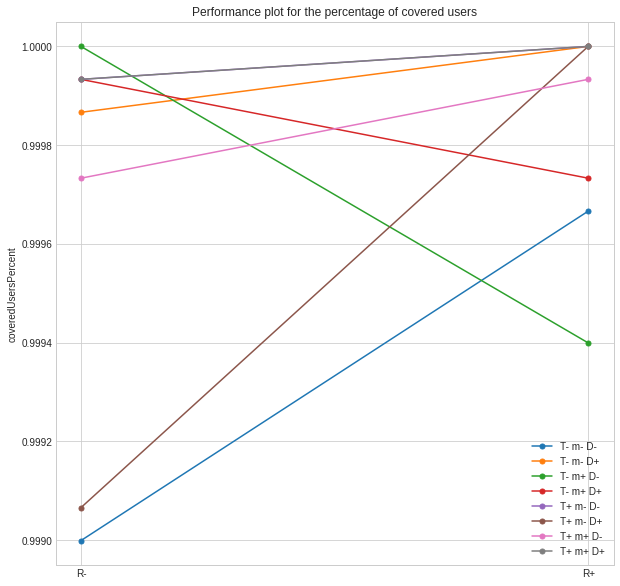

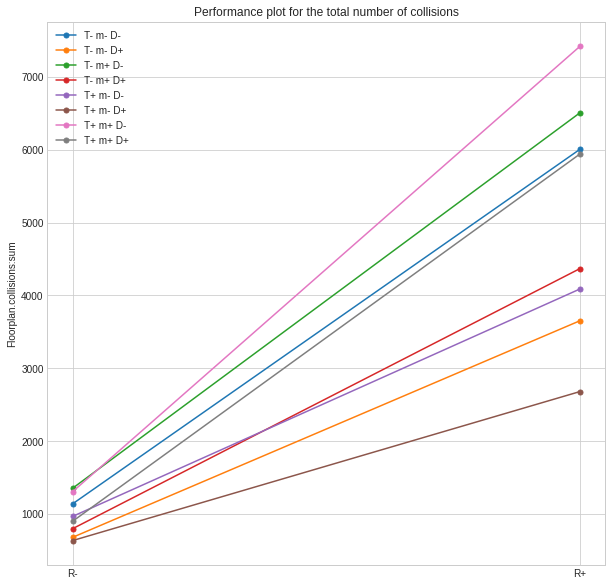

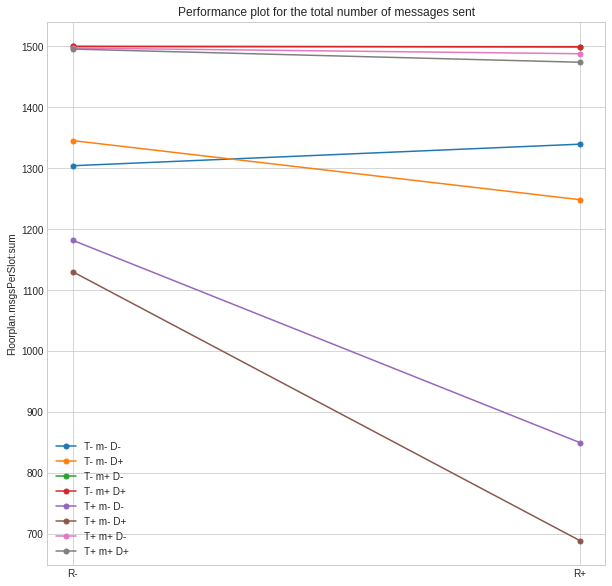

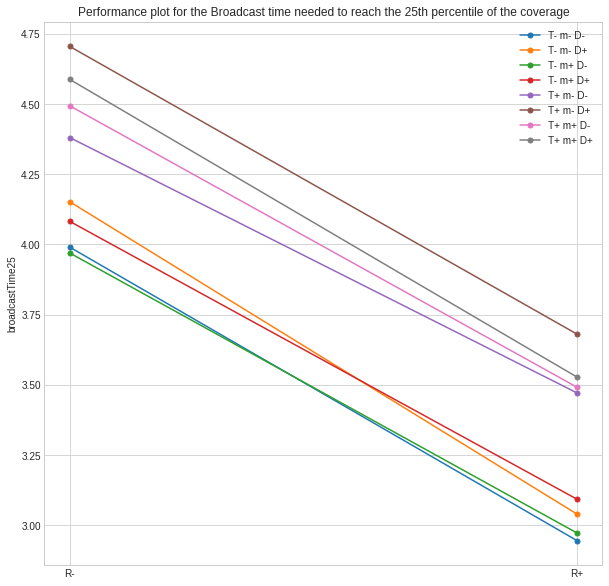

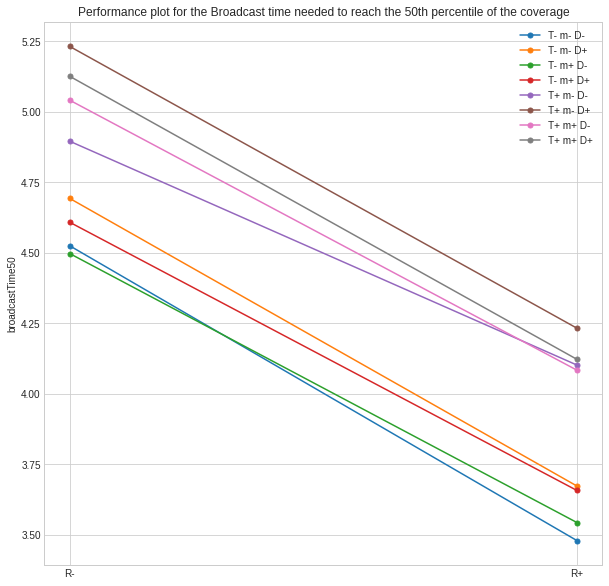

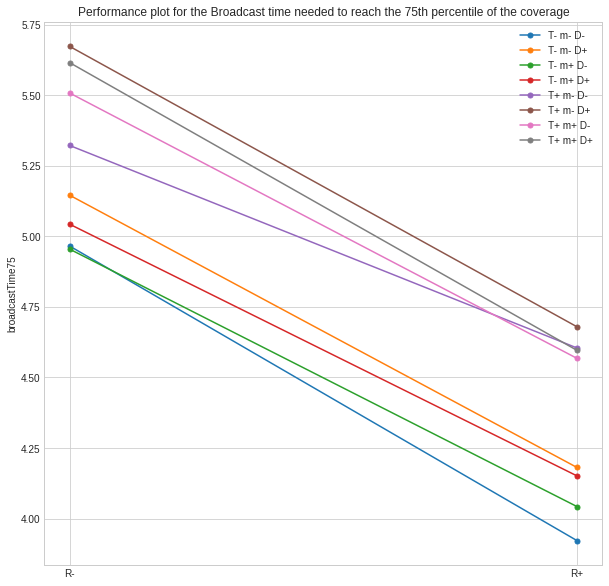

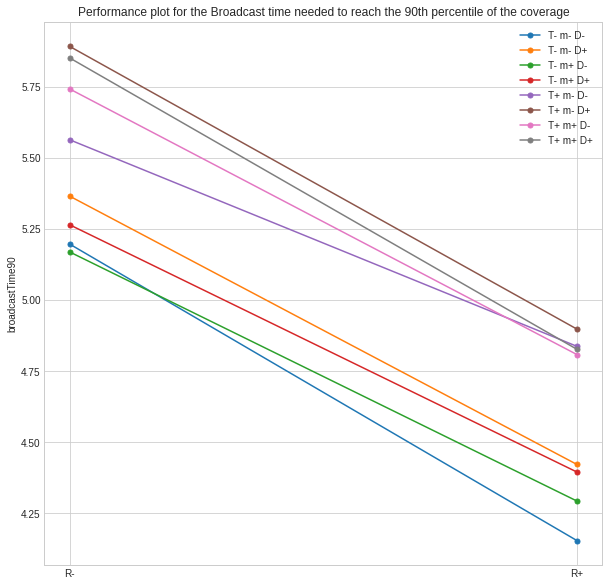

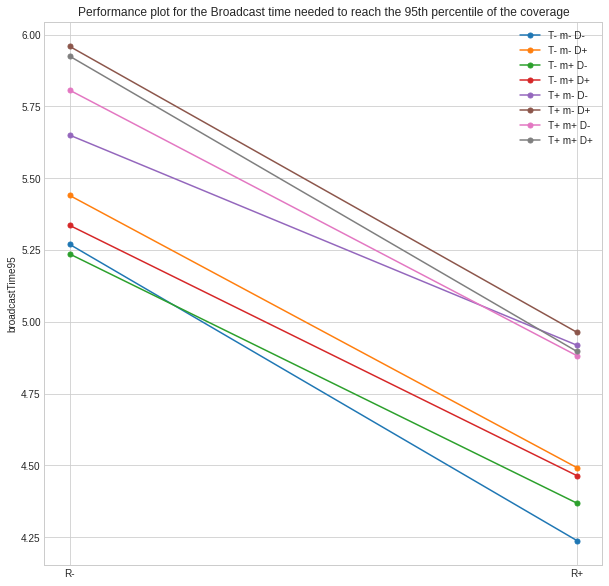

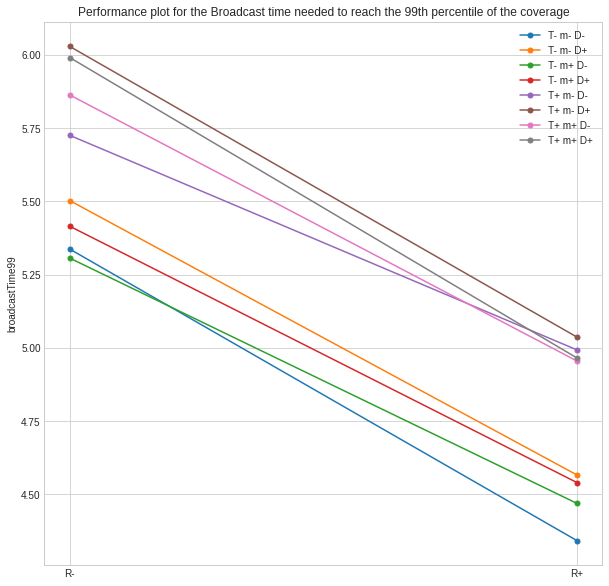

###########################

Plotting with T on the x axis...


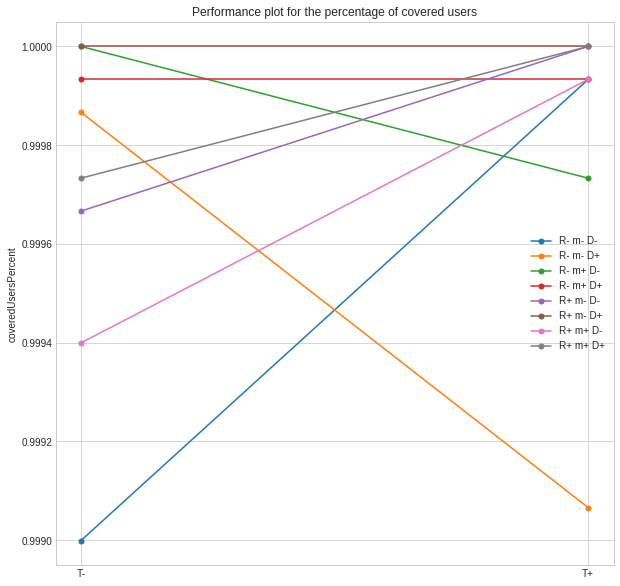

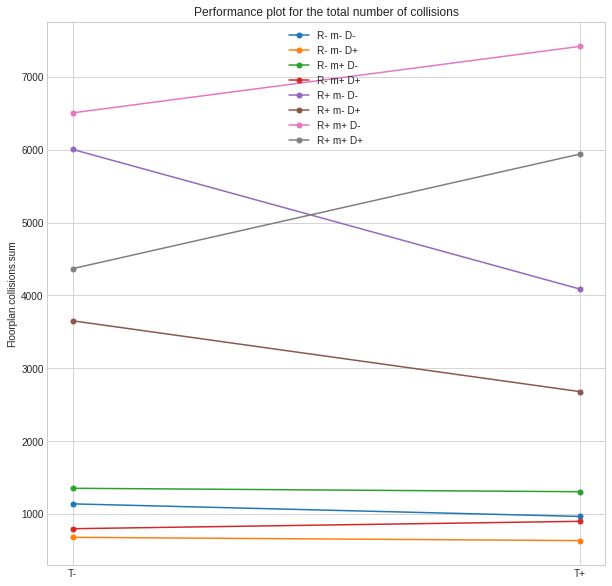

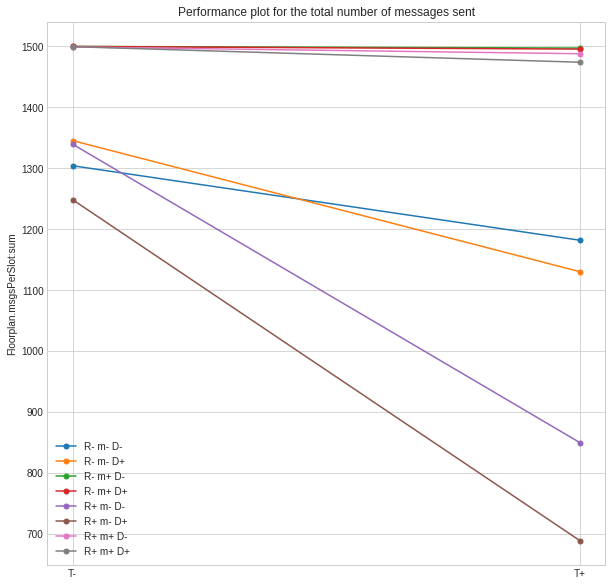

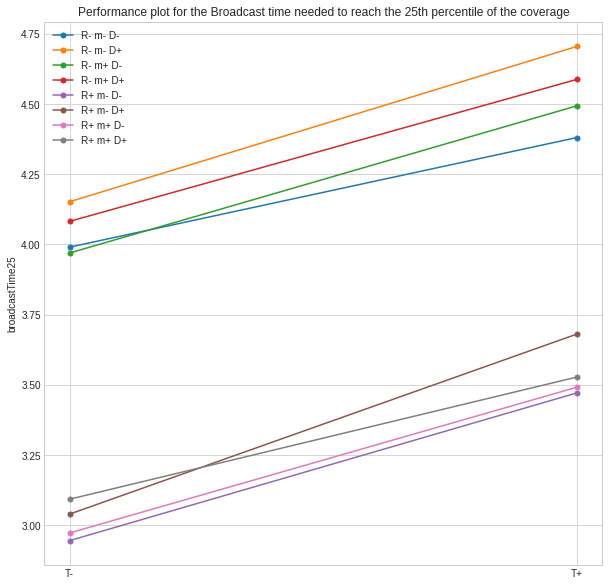

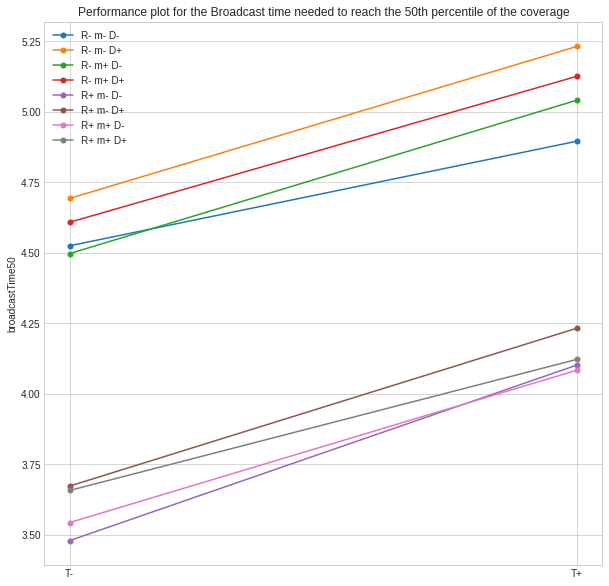

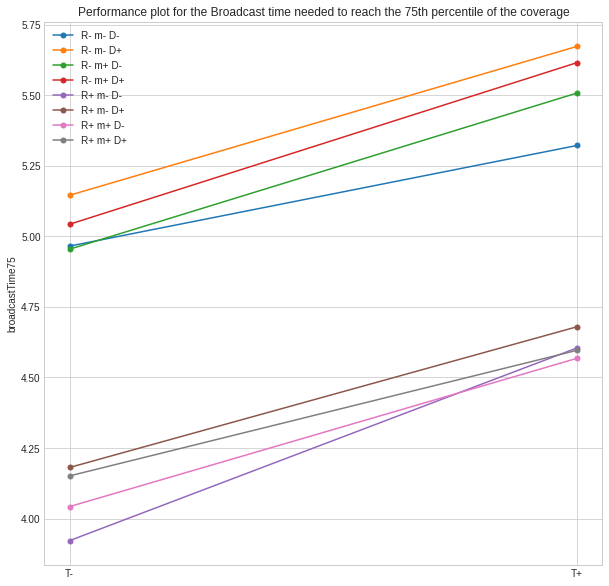

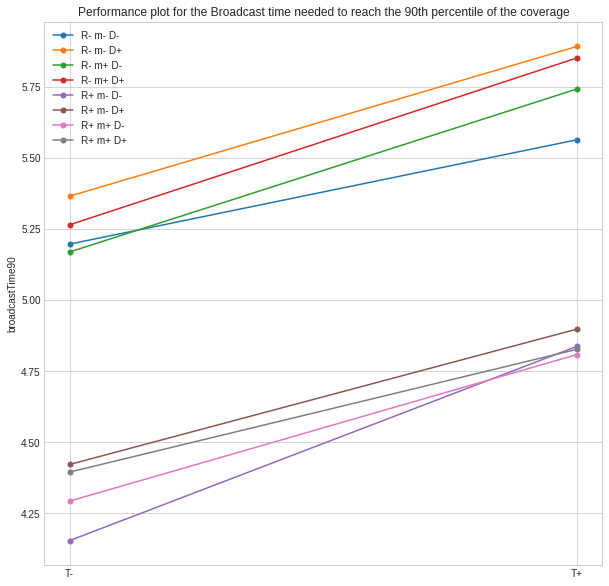

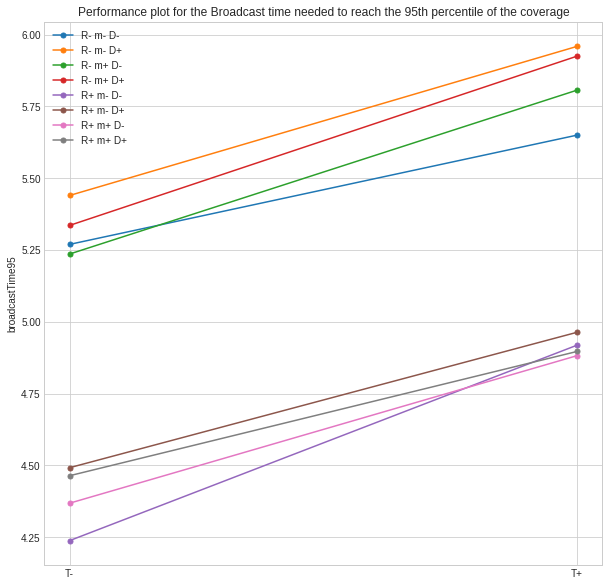

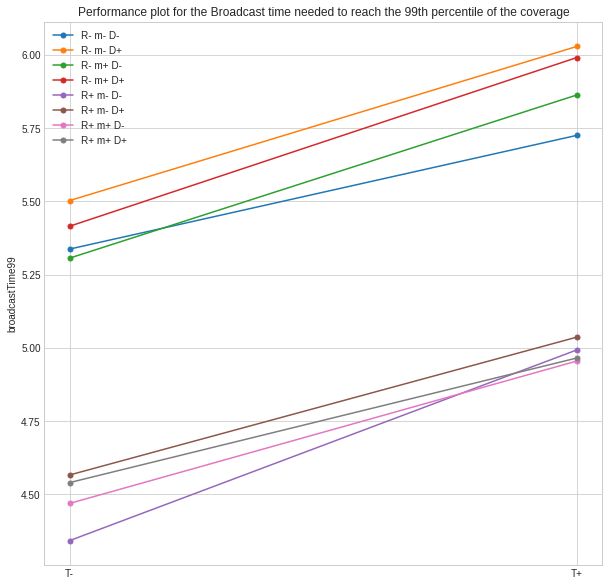

###########################

Plotting with m on the x axis...


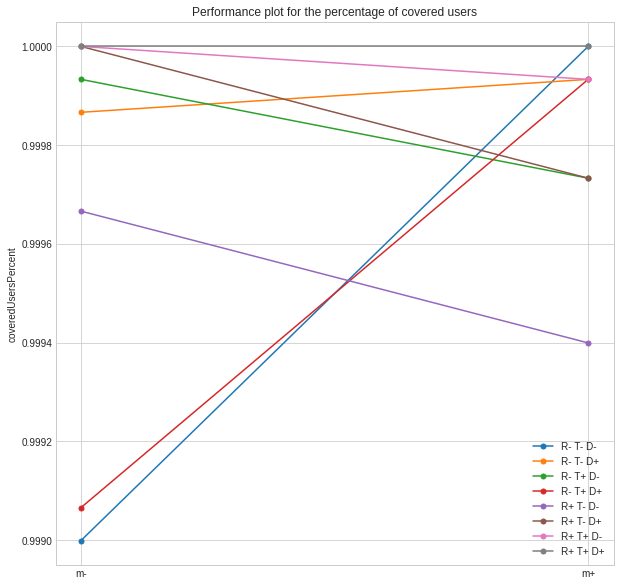

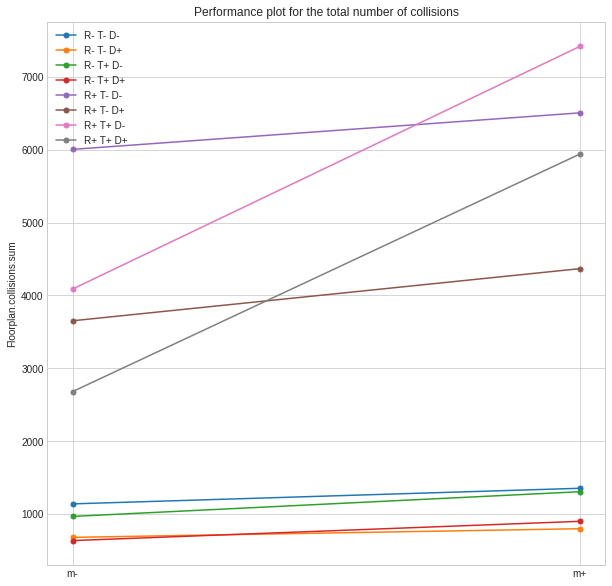

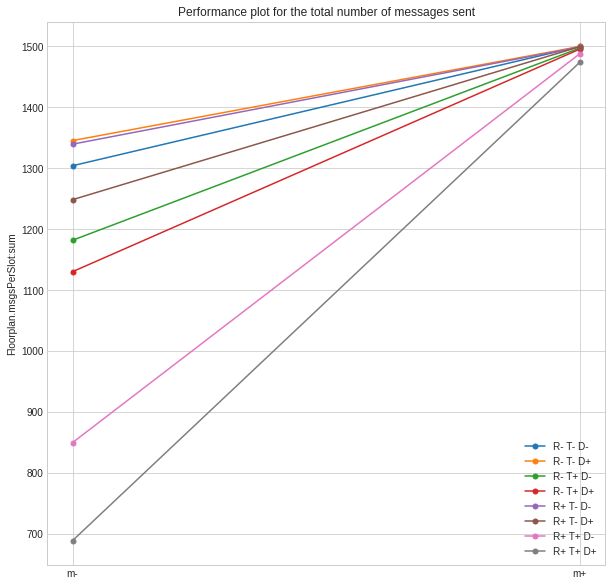

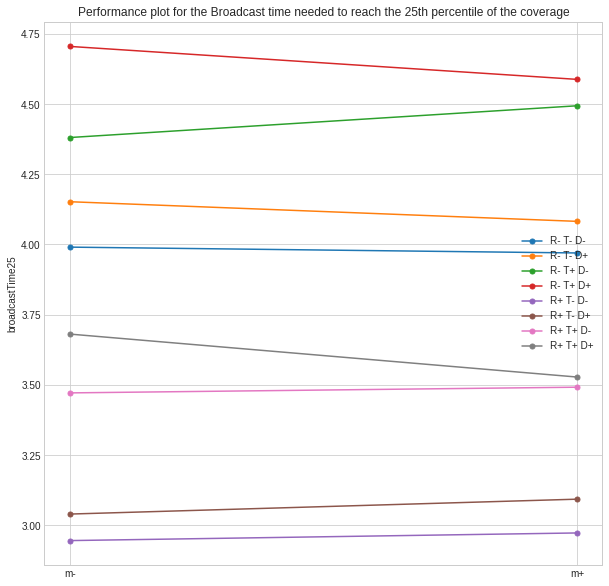

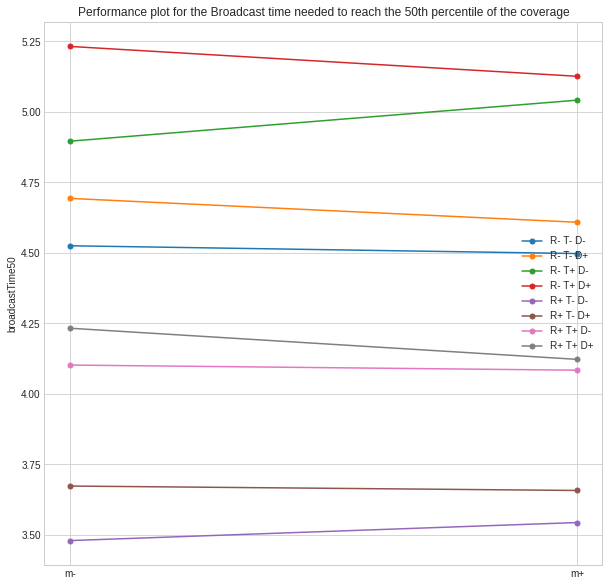

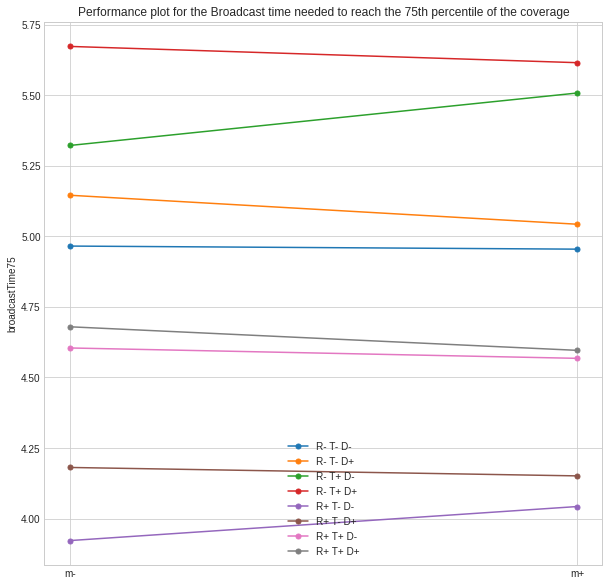

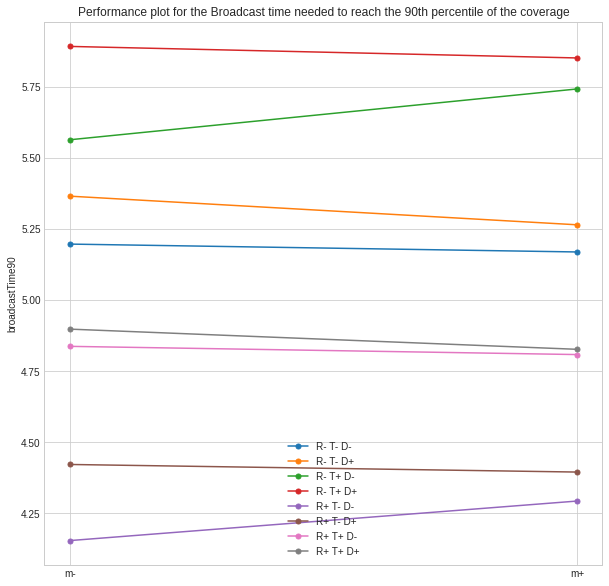

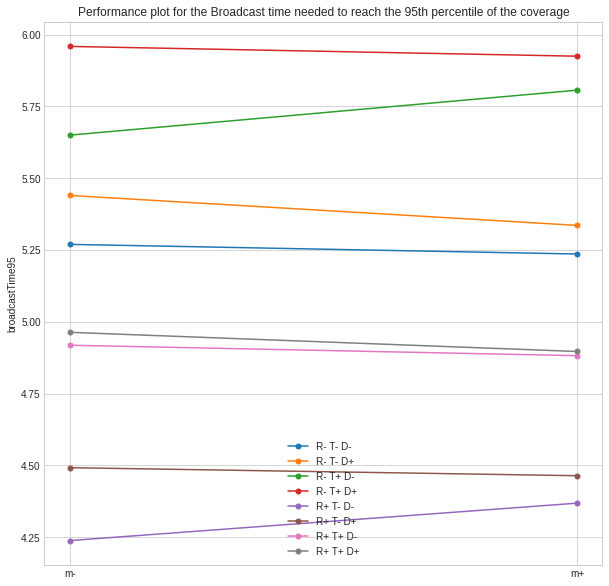

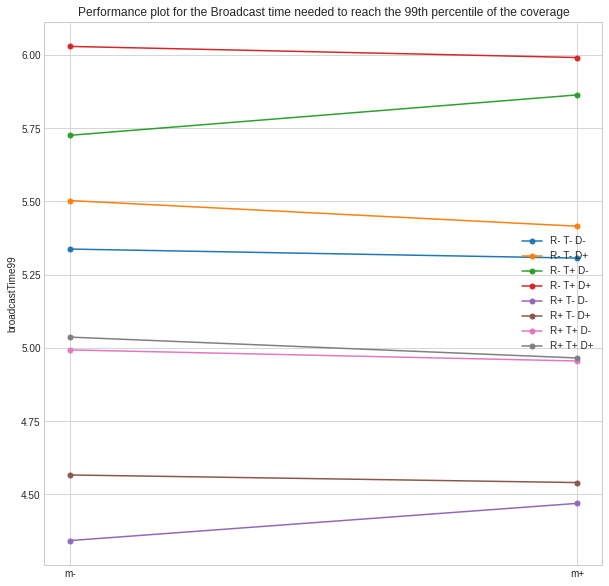

###########################

Plotting with D on the x axis...


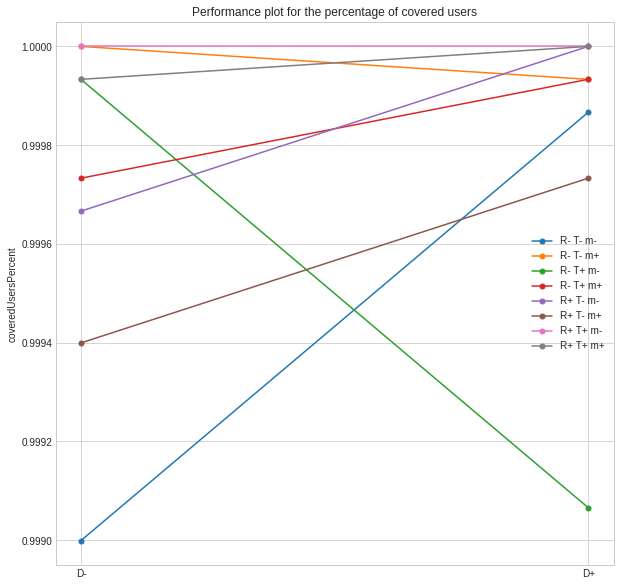

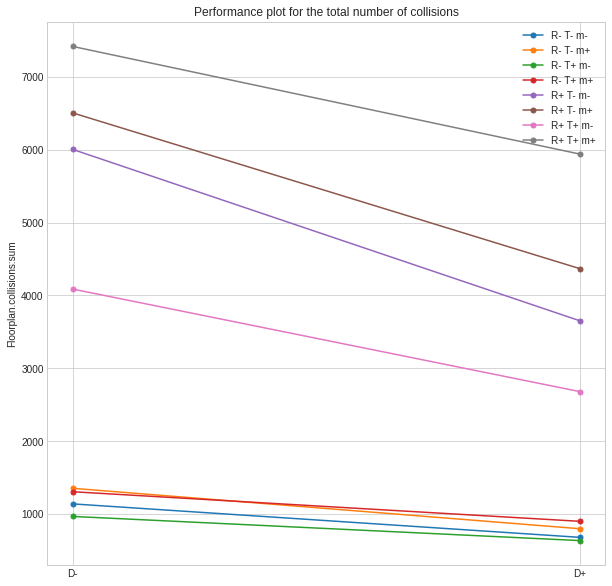

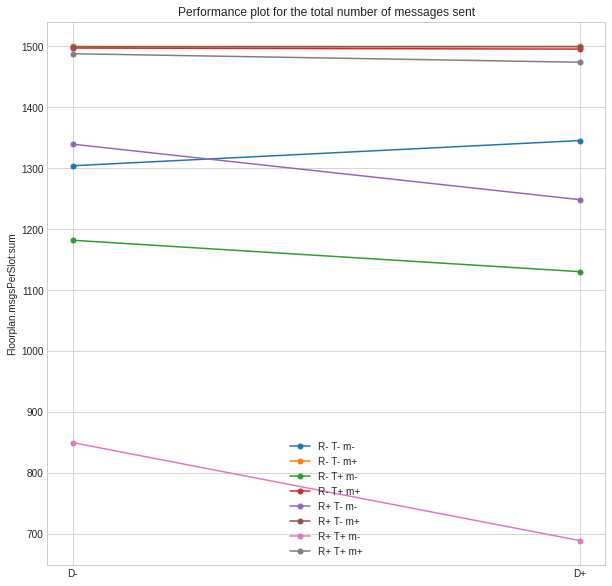

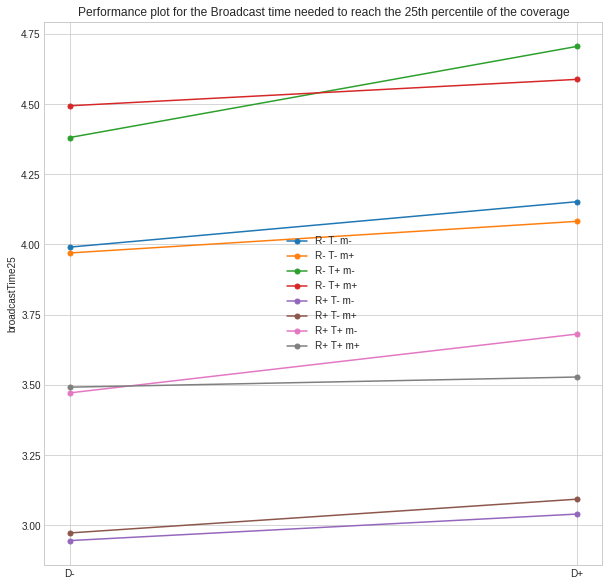

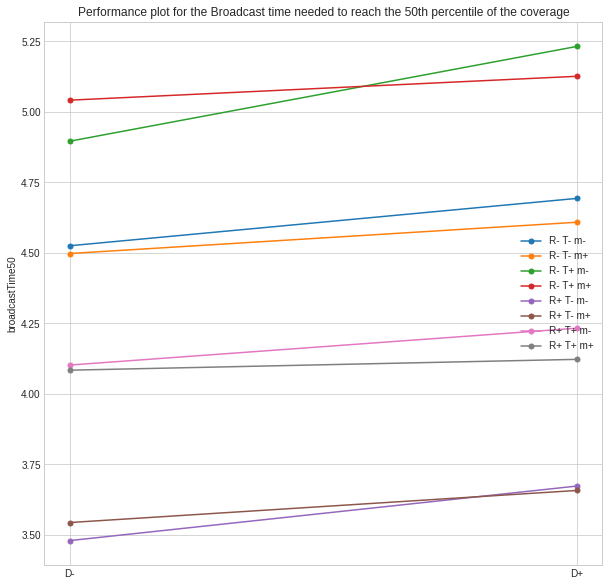

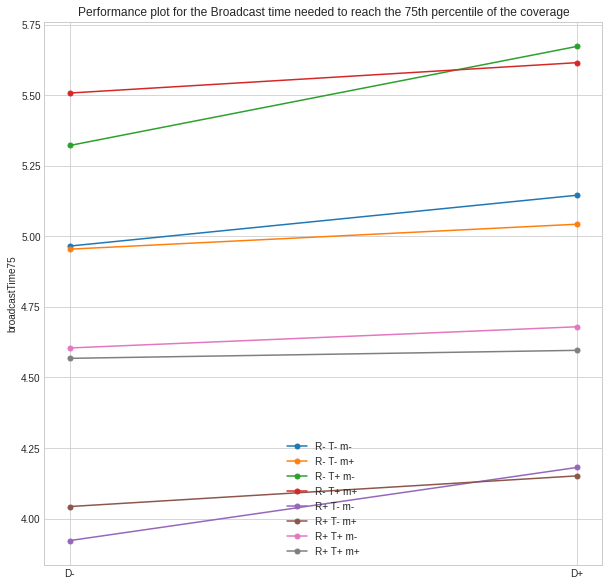

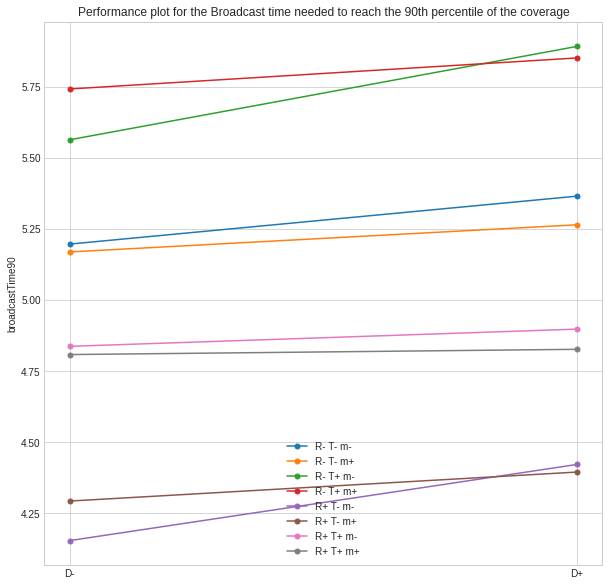

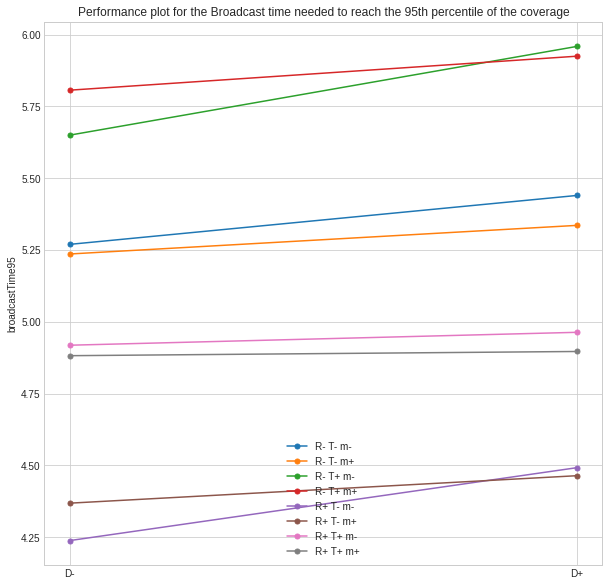

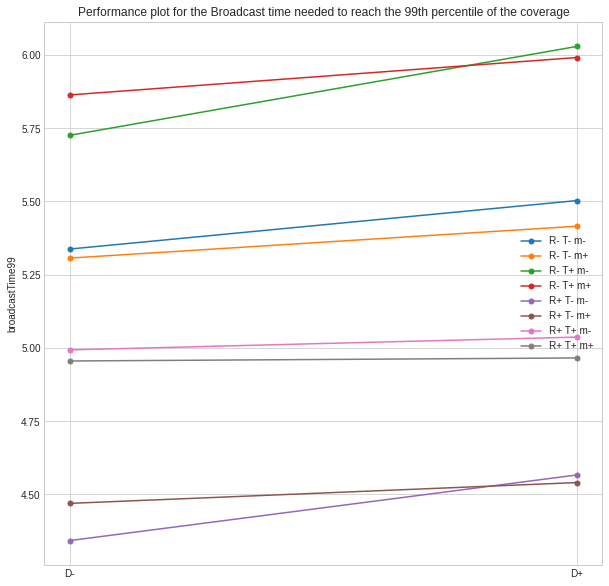

###########################



In [10]:
for xFactor in factors:
    print('Plotting with', xFactor, 'on the x axis...')
    xarr = np.array([-1, 1])
    idx = 0
    factorsMatrix.sort_values([xFactor] + [fac for fac in factors if fac != xFactor], inplace=True)
    for perfIndex, perfIndexDesc in perfIndexes:
        if perfIndex in skipped:
            continue
        ys = []
        fs = []
        for _, row in factorsMatrix.iterrows():
            y = np.sum(row[['I'] + combinedFactors].values * computeMatrices[idx].loc['Mean (Qi)', ['I'] + combinedFactors].values)
            fs.append(' '.join([f + str('+' if row[f] == 1 else '-') for f in [fac for fac in factors if fac != xFactor]]))
            ys.append(y)

        plt.figure(figsize=plotSize)
        plt.style.use(plotStyle)
        plt.xticks(xarr, (xFactor + '-', xFactor + '+'))
        ys = [y for y in zip(ys[:configsCount//2], ys[configsCount//2:])]
        for y, lbl in zip(ys, fs):
            yarr = np.array(y)
            plt.plot(xarr, yarr, linestyle='-', marker='.', markersize=10, label=lbl)
        plt.title('Performance plot for the ' + perfIndexDesc)
        plt.ylabel(perfIndex)
        plt.legend()
        if saveFigures:
            fig = plt.gcf()
            fig.savefig('figures/' + get_file_name(perfIndex) + '-' + xFactor + '-perfplot.png')
        plt.show()
        idx += 1
    print('###########################')
    print()